# Augmentation 1

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.datasets import cifar10
%matplotlib inline

In [8]:
trainset_size = len(full_trainset)
testset_size = len(testset)
trainset_size, testset_size

(50000, 10000)

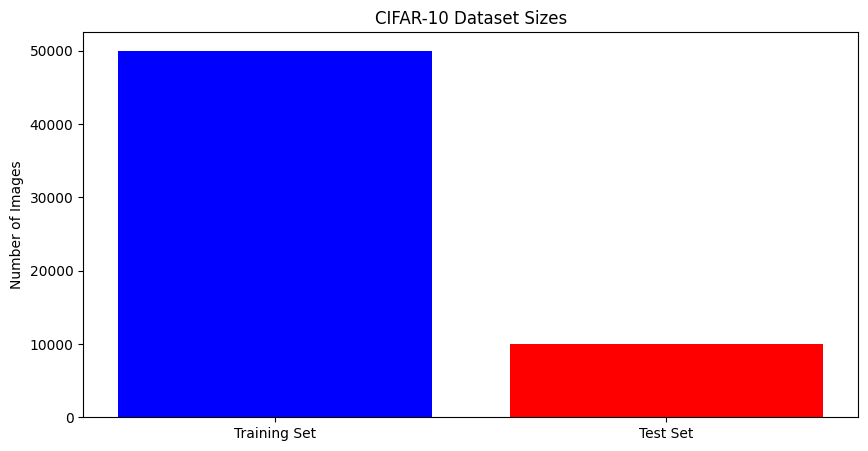

In [9]:
import matplotlib.pyplot as plt

# 데이터셋 크기를 저장할 리스트
dataset_sizes = [trainset_size, testset_size]
dataset_names = ["Training Set", "Test Set"]

plt.figure(figsize=(10, 5))
plt.bar(dataset_names, dataset_sizes, color=['blue', 'red'])
plt.title("CIFAR-10 Dataset Sizes")
plt.ylabel("Number of Images")
plt.show()

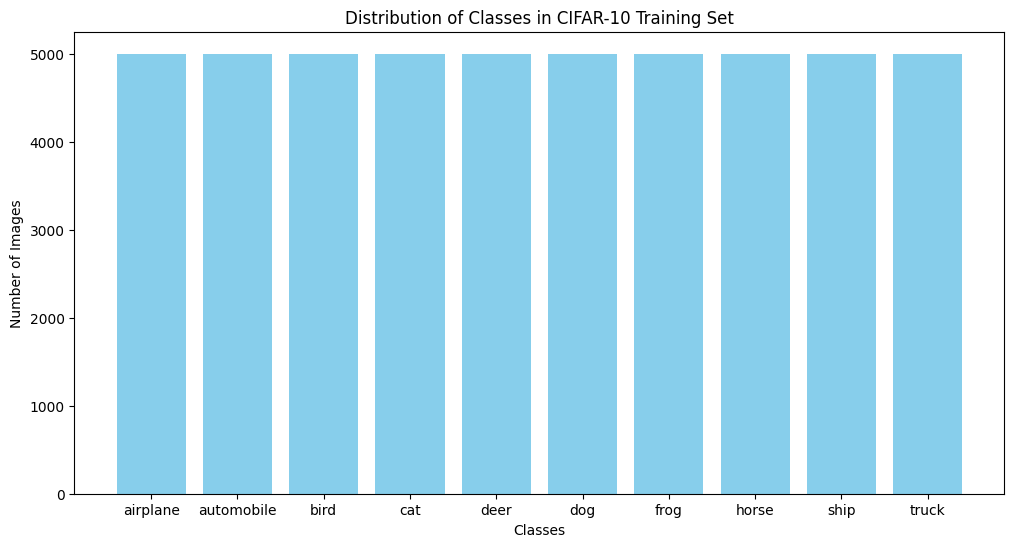

In [11]:
# 각 클래스의 샘플 수를 카운트
class_counts = np.zeros(10)
for _, label in full_trainset:
    class_counts[label] += 1

# 바 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in CIFAR-10 Training Set')
plt.show()

CIFAR-10의 경우 trainset 50000개 test set 10000개로 이루어져 있고 trainset은 각 클라스 별(10개) 5000개씩의 image로 구성되어 있다. 데이터셋의 크기는 주관적이다. 하지만 캐글에서 개 고양이를 classifying하기 위한 데이터셋이 25000개의 이미지로 이루어져 있다는 것을 볼 경우 상대적으로 작다는 생각이 들었다. 작은 데이터셋의 과 적합 문제를 해결하기 위해 image augmentation을 통해 전처리가 필요할 것으로 판단된다.

170498071/170498071 [==============================] - 45s 0us/step


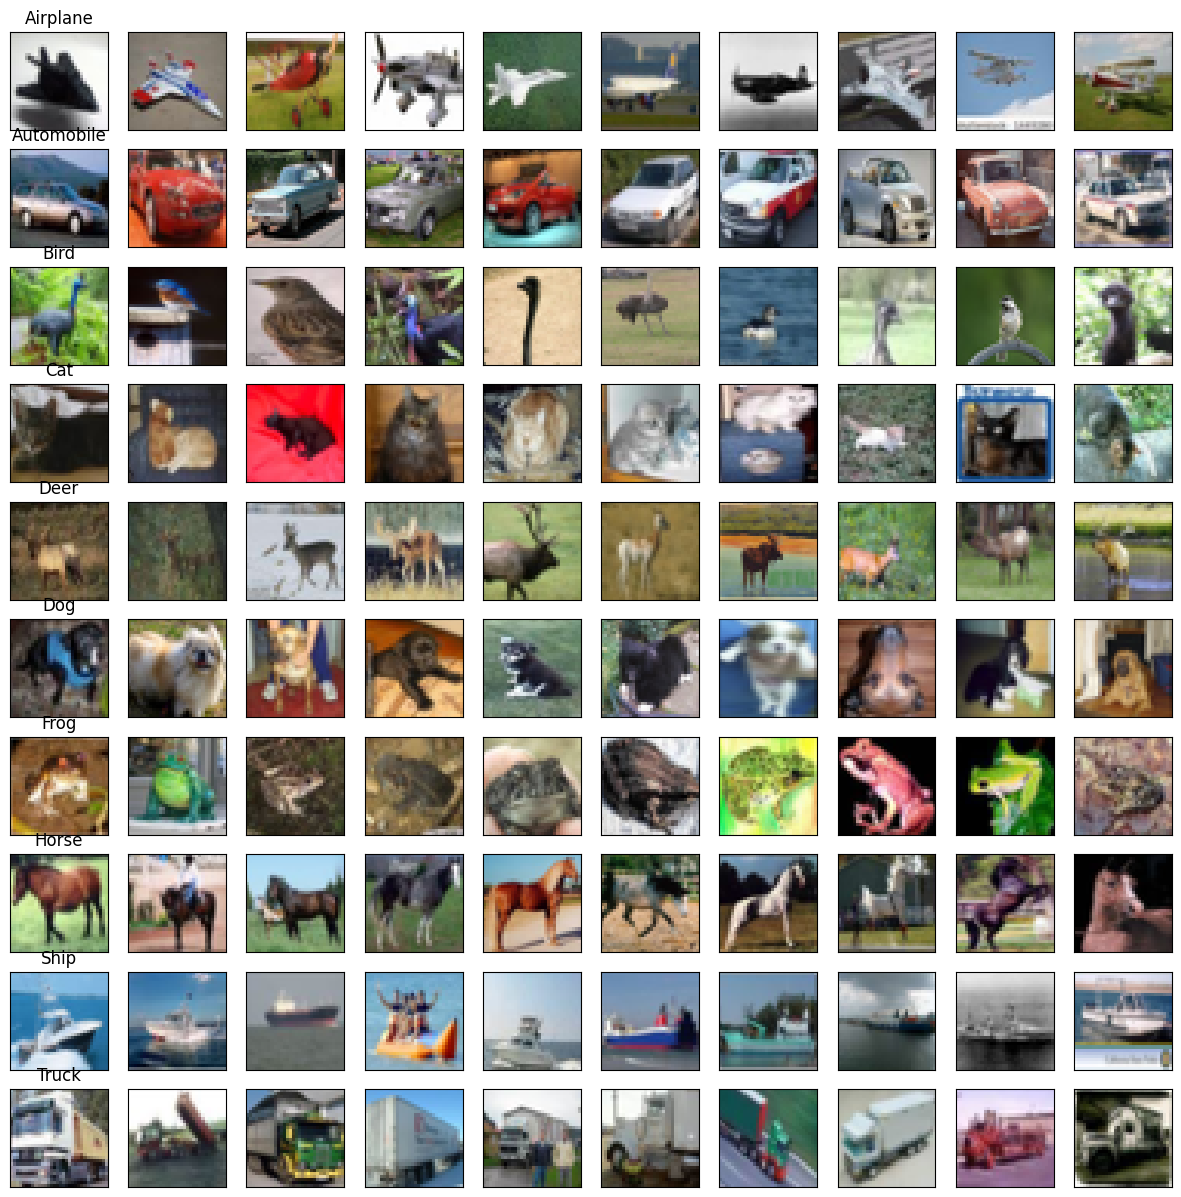

In [13]:
# Load CIFAR-10 dataset
(train_images, train_labels), (_, _) = cifar10.load_data()

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Initialize a dictionary to store images class-wise
classwise_images = {class_name: [] for class_name in class_names}

# Populate the dictionary with images for each class
for img, label in zip(train_images, train_labels):
    class_name = class_names[label[0]]
    if len(classwise_images[class_name]) < 10:
        classwise_images[class_name].append(img)

# Plotting the images
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(class_names):
    imgs = classwise_images[class_name]
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        if j == 0:
            plt.title(class_name)

plt.show()


각 클래스별 사진을 10개씩 plot한 결과이다. CIFAR-10의 이미지들은 32x32로 구성되어 있다.  위 사진에서 보면 각 사진들은 다양한 각도에서 객체를 촬영하였다. 대부분의 사진들은 피사체가 중앙에 위치한 것을 볼 수 있다. 또한 각 클래스의 객체들의 배경색상과 객체 색상이 다양한 것을 볼 수 있다.

In [2]:
from torch.nn.modules.dropout import Dropout2d
# Simplenet 모델 정의
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(512, 2048, 1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),

            nn.Conv2d(2048, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 256, 3,padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )
        self.classifier = nn.Linear(256, 10)



    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


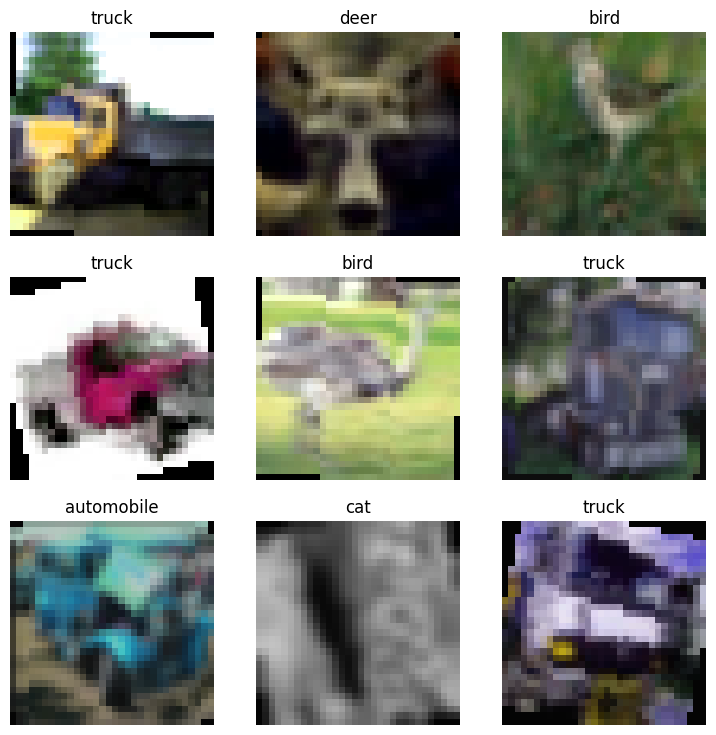

In [6]:
# 클래스 레이블
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 데이터 증강 설정
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2)
])

# 테스트 데이터는 증강하지 않음
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 데이터셋 로드 (전체)
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# DataLoader를 사용하지 않고 데이터와 레이블 추출
full_train_data = list(full_trainset)
train_data, val_data = train_test_split(full_train_data, test_size=0.2, random_state=42)

# 훈련 데이터와 검증 데이터로 DataLoader 설정
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 데이터 로더에서 하나의 배치를 불러오기 위해 for 루프 사용
for images, labels in trainloader:
    break  # 하나의 배치만 필요하므로 루프를 즉시 중단

# 이미지와 레이블을 3x3 그리드로 표시
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    img = images[i] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    ax.set_title(classes[labels[i]])
plt.show()

image augmentation이 진행된 이미지 샘플 출력

Epoch 1, Training Loss: 1.6018615884780885, Train Acc: 0.4152, Validation Loss: 1.4785268124501416, Validation Acc: 0.4733
Epoch 2, Training Loss: 1.2106186930656433, Train Acc: 0.5713, Validation Loss: 1.2508704134613087, Validation Acc: 0.5636
Epoch 3, Training Loss: 1.0317901766777038, Train Acc: 0.6368, Validation Loss: 1.0877711347713592, Validation Acc: 0.6216
Epoch 4, Training Loss: 0.9140554901123047, Train Acc: 0.6844, Validation Loss: 0.9321538973006473, Validation Acc: 0.6792
Epoch 5, Training Loss: 0.835224317741394, Train Acc: 0.7107, Validation Loss: 0.8610829456596617, Validation Acc: 0.7033
Epoch 6, Training Loss: 0.7604435853004455, Train Acc: 0.7374, Validation Loss: 0.8448590218641197, Validation Acc: 0.7122
Epoch 7, Training Loss: 0.7026469950199127, Train Acc: 0.7605, Validation Loss: 0.8403940383036426, Validation Acc: 0.7161
Epoch 8, Training Loss: 0.6461455485343933, Train Acc: 0.7793, Validation Loss: 0.7994419359097815, Validation Acc: 0.7284
Epoch 9, Training

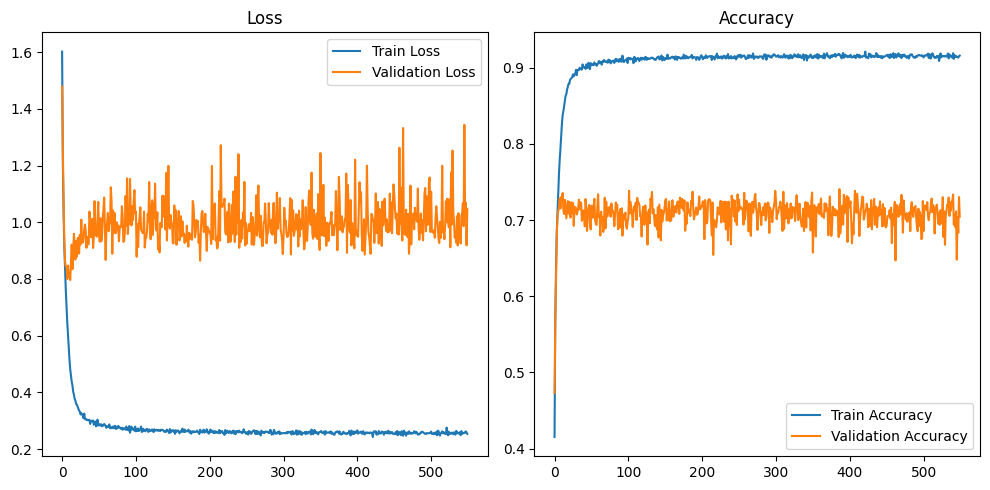

In [4]:
# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델, 손실 함수, 옵티마이저
model = SimpleNet().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=0.001, weight_decay=0.002)

# 손실 및 정확도 리스트
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []



    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to("cuda"), labels.to("cuda")

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    avg_train_loss = running_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    val_acc = val_corrects.double().item() / len(valloader.dataset)
    train_acc = train_corrects.double().item() / len(trainloader.dataset)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Train Acc: {train_acc:.4f}, Validation Loss: {avg_val_loss}, Validation Acc: {val_acc:.4f}")

# 손실 및 정확도 그래프 그리기
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()


Test Loss: 0.7635, Test Acc: 0.7830


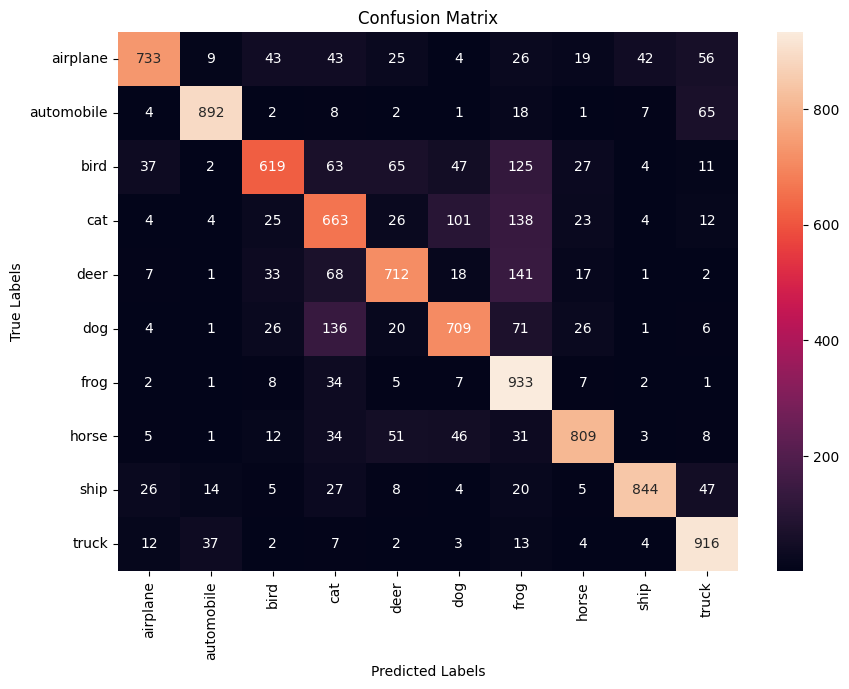

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터셋에 대한 성능을 평가하기 위한 변수 초기화
test_loss = 0.0
test_corrects = 0

# Confusion matrix를 위한 레이블과 예측값을 저장할 리스트
true_labels = []
pred_labels = []

# GPU 설정 (이미 설정되어 있다면 생략 가능)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in testloader:
        # 데이터를 GPU로 옮김 (이미 옮겨져 있다면 생략 가능)
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델을 통해 예측 실행
        outputs = model(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 테스트 손실 업데이트
        test_loss += loss.item() * inputs.size(0)

        # 예측값 계산
        _, preds = torch.max(outputs, 1)

        # 정확도 계산
        test_corrects += torch.sum(preds == labels.data)

        # 레이블과 예측값을 리스트에 추가
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# 평균 테스트 손실과 정확도 계산
test_loss = test_loss / len(testloader.dataset)
test_acc = test_corrects.double() / len(testloader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Confusion matrix 계산
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Confusion matrix를 그림으로 표시
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d",xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
